# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import findspark

findspark.init()


In [2]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.functions import avg, col, concat, desc, explode, \
        lit, min, max, sum, count, split, udf, to_date, from_unixtime, datediff, when, countDistinct, date_add

from pyspark.sql import DataFrame
from pyspark.sql import types

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
mini_dataset = "mini_sparkify_event_data.json"

df = spark.read.json(mini_dataset)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [57]:
real_dataset = "../sparkify_event_data.json"

df_real = spark.read.json(real_dataset)
df_real.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
# List attributes of data points

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Convert to Pandas Dataframe for initial analysis on smaller dataset

df_pd = df.toPandas()

In [8]:
# List counts of each attributes

df_pd.count()

artist           228108
auth             286500
firstName        278154
gender           278154
itemInSession    286500
lastName         278154
length           228108
level            286500
location         278154
method           286500
page             286500
registration     278154
sessionId        286500
song             228108
status           286500
ts               286500
userAgent        278154
userId           286500
dtype: int64

In [9]:
df_pd.head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


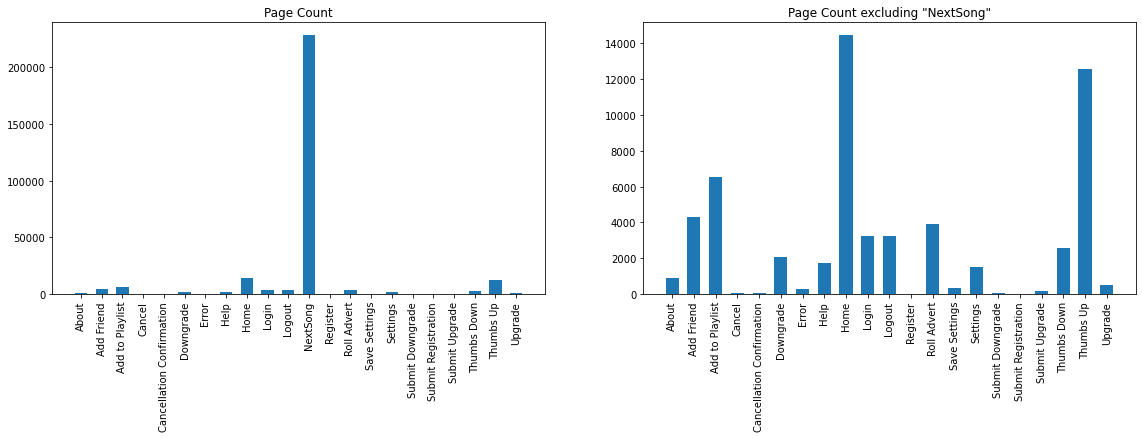

In [10]:
# Let's focus on 'Page' attributes

# List the counts of each value on 'page'


group_data = df_pd.groupby(['page'])
bar_names = group_data.count().index
bar_values = group_data.count()['userId']
y_pos = range(len(bar_names))

plt.figure(figsize=(30, 5))

ax1 = plt.subplot(131)
ax1.title.set_text('Page Count')
plt.bar(bar_names, bar_values, 0.6)
plt.xticks(y_pos, bar_names, rotation=90)

group_data = df_pd[df_pd['page'] != 'NextSong'].groupby(['page'])
bar_names = group_data.count().index
bar_values = group_data.count()['userId']
y_pos = range(len(bar_names))

ax2 = plt.subplot(132)
ax2.title.set_text('Page Count excluding "NextSong"')
plt.bar(bar_names, bar_values, 0.6)
plt.xticks(y_pos, bar_names, rotation=90)

plt.show()

#### Count each value on 'page'

From bar chart 'Page Count', 'NextSong' is most used actions, which are far more than others.

After excluding 'NextSong' from dataset, 'Home', 'Thumbs Up', 'Add to Playlist' are three most of actions.

In [11]:
# data clean
# check if user id is None
# Number of records have no 'userId'

df.where((df.userId == "") | (df.userId.isNull())).count()

8346

In [12]:
# Remove records which have no 'userId'

df = df.where((df.userId != "") & (df.userId.isNotNull()))

In [59]:
# Remove records which have no 'userId'

df_real = df_real.where((df_real.userId != "") & (df_real.userId.isNotNull()))

In [13]:
# Get list of user ids which have churn out.

df_churn = df.where(col('page') == 'Cancellation Confirmation').select(col('userId').alias('userId'), lit(1).alias('churn')).distinct()

In [61]:
# Get list of user ids which have churn out.

df_real_churn = df_real.where(col('page') == 'Cancellation Confirmation').select(col('userId').alias('userId'), lit(1).alias('churn')).distinct()

In [14]:
# Number of total users from the dataset.

total_users = df.select(col('userId')).distinct().count()
churn_users = df_churn.count()

print("Total users: {}".format(total_users))
print("Churn users: {}".format(churn_users))
print("Churn rate:  {}".format(churn_users / total_users))

Total users: 225
Churn users: 52
Churn rate:  0.2311111111111111


### ####
Metrics by User

- number of songs played
- number of artist played
- number of active days
- number of active days for past N days before downgrade
- number of active days for past N days before cancelled
- number of active days since registration
- number of days being 'Paid' member
- number of days being 'Free' member
- average songs played per active day
- total seconds of played 

### ####

In [15]:
# Convert timestamp to Date
# Create columns -> 'registration_datetime' and 'event_datetime', 'days_from_registration'

df = df.withColumn('event_date', from_unixtime(col('ts').cast('bigint') / 1000, 'yyyy-MM-dd')) \
       .withColumn('registration_date', from_unixtime(col('registration').cast('bigint') / 1000, 'yyyy-MM-dd')) \
       .withColumn('days_from_registration', datediff(col('event_date'), col('registration_date'))) 

In [60]:
df_real = df_real.withColumn('event_date', from_unixtime(col('ts').cast('bigint') / 1000, 'yyyy-MM-dd')) \
       .withColumn('registration_date', from_unixtime(col('registration').cast('bigint') / 1000, 'yyyy-MM-dd')) \
       .withColumn('days_from_registration', datediff(col('event_date'), col('registration_date'))) 

In [16]:
def extract_past_N_days(df: DataFrame, \
                        days: types.IntegerType, \
                        date_col_event: types.StringType) -> DataFrame:
    ''' Extract past N days data from a dataframe
    
    Parameters:
        df (DataFrame): a dataframe
        days (Integer): a number of days
        date_col_event (String): date column name used to check if a record is within the date range
    Returns:
        df_new: a dataframe contains only specitifed days' data
    
    '''
    try:
        df_max_date = df.groupBy('userId').agg(max(date_col_event).alias('date_to'))
        
        df_new = \
            df.join(df_max_date, on='userId', how='inner') \
              .where(datediff(col('date_to'), col(date_col_event)) < days) \
              .withColumn('date_from', \
                          when(datediff(col('date_to'), col('registration_date')) < days, col('registration_date')).otherwise(date_add(col('date_to'), -1*days+1)) \
                         )
        
    except Py4JJavaError as e:
        
        df_new = sc.emptyRDD()
        
    return df_new

In [17]:
def Normalize_Data_ToUser(df: DataFrame) -> DataFrame:
    '''Normalize Raw dataframe to User Based. After this transformation, each record will be usedId based. 
    
    Parameters:
        df (DataFrame): raw data frame
        
    Returns:
        df_new (DataFrame): normalized dataframe (user-based)
    '''

    df_userId = df.groupBy('userId')

    df_days = \
        df_userId.agg(countDistinct('event_date').alias('num_active_days'), \
                      min('date_from').alias('date_from'),                  \
                      max('date_to').alias('date_to'),                      \
                      min('registration_date').alias('registration_date')   \
                      )
    df_current_level = \
        df.where(col('event_date') == col('date_to')) \
          .groupBy('userId') \
          .agg(min('level').alias('current_level')) \
          .withColumn('current_level_paid', when(col('current_level') == 'paid', 1).otherwise(0))
    
    df_pages = \
        df_userId.pivot("page") \
           .agg(count('page'))    
    
    df_songs = \
        df.where(col('page') == 'NextSong') \
          .groupBy('userId') \
          .agg(count('page').alias('num_songs'), countDistinct('song').alias('num_songs_unique'))

    df_artists = \
        df.where(col('page') == 'NextSong') \
          .groupBy('userId') \
          .agg(countDistinct('artist').alias('num_artist'), \
               sum('length').alias('total_play_length') \
              )    

    df_active_days_as_paid = \
        df.where(col('level') == 'paid').groupBy('userId') \
          .agg(countDistinct('event_date').alias('num_active_days_paid'))

    df_new = \
        df_songs.join(df_artists, on='userId', how='left') \
                .join(df_days, on='userId', how='left') \
                .join(df_active_days_as_paid, on='userId', how='left') \
                .join(df_pages, on='userId', how='left') \
                .join(df_current_level, on='userId', how='left') \
                .select(col('*'), \
                        (datediff(col('date_to'), col('registration_date'))+1).alias('days_since_registration'), \
                        (datediff(col('date_to'), col('date_from'))+1).alias('days_in_member') ) \
                .withColumn('active_pct', (col('num_active_days') / col('days_in_member'))) \
                .withColumn('avg_songs_per_day', col('num_songs') / col('days_in_member')) \
                .withColumn('avg_songs_per_active_day', col('num_songs') / col('num_active_days')) \
                .withColumn('avg_play_length_per_day', col('total_play_length') / col('days_in_member')) \
                .withColumn('avg_play_length_per_active_day', col('total_play_length') / col('num_active_days')) 

    return df_new


In [18]:
def Apply_Churn_Flag(df: DataFrame, df_churn: DataFrame) -> DataFrame:
    '''Add 'Churn' flag to df
    
    Parameters:
        df (DataFrame): normalized dataframe
        df_churn (DataFrame): list of churn users 
        
    Return:
        df_new (DataFrame): new dataframe with a churn flag value -> 1
    '''
    
    df_new = df.join(df_churn, on='userId', how='left') \
               .withColumn('churn', when(col('churn') == 1, 1).otherwise(0))
    
    return df_new
    

In [19]:
N_days=3000 # Assume we extract all records from the exisintg smaller dataset.

df_N_days = Apply_Churn_Flag(Normalize_Data_ToUser(extract_past_N_days(df, days=N_days, date_col_event='event_date')), df_churn)

In [62]:
N_days=3000 # Assume we extract all records from the exisintg smaller dataset.

df_real_N_days = Apply_Churn_Flag(Normalize_Data_ToUser(extract_past_N_days(df_real, days=N_days, date_col_event='event_date')), df_real_churn)

In [20]:
df_N_pd = df_N_days.toPandas()

In [63]:
df_real_N_pd = df_real_N_days.toPandas()

In [64]:
df_real_N_pd.describe()

,num_songs,num_songs_unique,num_artist,total_play_length,num_active_days,num_active_days_paid,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Login,Logout,NextSong,Register,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Registration,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,current_level_paid,days_since_registration,days_in_member,active_pct,avg_songs_per_day,avg_songs_per_active_day,avg_play_length_per_day,avg_play_length_per_active_day,churn
count,22261.000000,22261.000000,22261.000000,2.226100e+04,22261.000000,16182.000000,14458.000000,20305.000000,21260.000000,5002.0,5002.0,15209.000000,11272.000000,18243.000000,22056.000000,0.0,21159.000000,22261.000000,0.0,20068.000000,12237.000000,18932.000000,5103.000000,0.0,12082.000000,20031.000000,21732.000000,16151.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000
mean,936.627824,829.202866,645.030726,2.329632e+05,13.318899,11.605117,3.345898,18.796553,28.124224,1.0,1.0,12.113880,2.222143,7.095763,42.306311,NaN,13.989508,936.627824,NaN,19.195336,2.412029,7.768434,1.272585,NaN,1.252690,11.942090,52.984769,3.127175,0.575805,84.496159,84.496159,0.177027,12.342389,60.124115,3069.498908,14952.542935,0.224698
std,1099.740881,894.631941,602.247974,2.735594e+05,10.873633,9.872729,3.044267,20.747704,32.274990,0.0,0.0,12.269845,1.739329,7.300929,45.955995,NaN,14.596206,1099.740881,NaN,20.888356,1.960724,7.986111,0.594934,NaN,0.579821,12.752729,64.867000,2.649315,0.494231,40.890947,40.890947,0.155731,15.014000,32.520814,3732.712216,8092.531232,0.417393
min,1.000000,1.000000,1.000000,7.849751e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,0.000000,-18.000000,-18.000000,-2.000000,-86.000000,0.500000,-21060.636950,78.497510,0.000000
25%,204.000000,200.000000,189.000000,5.071155e+04,5.000000,4.000000,1.000000,5.000000,6.000000,1.0,1.0,4.000000,1.000000,2.000000,12.000000,NaN,4.000000,204.000000,NaN,5.000000,1.000000,2.000000,1.000000,NaN,1.000000,3.000000,11.000000,1.000000,0.000000,62.000000,62.000000,0.069767,2.800000,34.444444,693.975837,8577.539243,0.000000
50%,553.000000,527.000000,463.000000,1.375060e+05,10.000000,9.000000,2.000000,12.000000,17.000000,1.0,1.0,8.000000,2.000000,5.000000,27.000000,NaN,9.000000,553.000000,NaN,13.000000,2.000000,5.000000,1.000000,NaN,1.000000,8.000000,31.000000,2.000000,1.000000,77.000000,77.000000,0.133333,7.230769,56.857143,1800.915656,14121.580166,0.000000
75%,1260.000000,1149.000000,926.000000,3.133939e+05,18.000000,16.000000,4.000000,25.000000,38.000000,1.0,1.0,16.000000,3.000000,9.000000,56.000000,NaN,18.000000,1260.000000,NaN,26.000000,3.000000,10.000000,1.000000,NaN,1.000000,16.000000,70.000000,4.000000,1.000000,101.000000,101.000000,0.239437,16.219512,81.166667,4035.964116,20177.030107,0.000000
max,11314.000000,7970.000000,4368.000000,2.807182e+06,62.000000,61.000000,33.000000,222.000000,340.000000,1.0,1.0,133.000000,21.000000,76.000000,446.000000,NaN,168.000000,11314.000000,NaN,269.000000,24.000000,80.000000,7.000000,NaN,8.000000,154.000000,836.000000,29.000000,1.000000,411.000000,411.000000,4.000000,286.000000,329.000000,69722.802550,81254.198610,1.000000


In [21]:
df_N_pd.describe()

,num_songs,num_songs_unique,num_artist,total_play_length,num_active_days,num_active_days_paid,About,Add Friend,Add to Playlist,Cancel,...,Upgrade,current_level_paid,days_since_registration,days_in_member,active_pct,avg_songs_per_day,avg_songs_per_active_day,avg_play_length_per_day,avg_play_length_per_active_day,churn
count,225.000000,225.000000,225.000000,2.250000e+02,225.000000,165.000000,155.000000,206.000000,215.000000,52.0,...,168.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,1013.813333,897.791111,696.377778,2.525583e+05,14.200000,12.642424,3.193548,20.762136,30.353488,1.0,...,2.970238,0.608889,80.942222,80.942222,0.197258,13.855891,62.148109,3450.651604,15480.106940,0.231111
std,1104.960779,896.387604,603.951870,2.753964e+05,11.250397,9.977384,3.310936,20.646779,32.852057,0.0,...,2.555786,0.489087,37.677571,37.677571,0.164986,15.566266,33.305057,3870.772889,8321.835975,0.422483
min,3.000000,3.000000,3.000000,6.916688e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,...,1.000000,0.000000,1.000000,1.000000,0.009901,0.081081,3.000000,21.573576,691.668840,0.000000
25%,230.000000,226.000000,207.000000,5.763318e+04,6.000000,5.000000,1.000000,7.000000,7.000000,1.0,...,1.000000,0.000000,61.000000,61.000000,0.083333,3.285714,36.700000,826.363537,9075.708422,0.000000
50%,675.000000,634.000000,555.000000,1.680938e+05,11.000000,11.000000,2.000000,16.000000,19.000000,1.0,...,2.000000,1.000000,74.000000,74.000000,0.150794,8.888889,60.306122,2191.833068,15037.173887,0.000000
75%,1571.000000,1420.000000,1098.000000,3.924015e+05,20.000000,18.000000,4.000000,28.000000,45.500000,1.0,...,4.000000,1.000000,102.000000,102.000000,0.263158,17.814433,83.166667,4477.295451,20643.809700,0.000000
max,8002.000000,5946.000000,3544.000000,1.991155e+06,61.000000,50.000000,25.000000,143.000000,240.000000,1.0,...,15.000000,1.000000,257.000000,257.000000,1.000000,105.550000,216.000000,26163.792140,54480.933870,1.000000


In [22]:
# Create a dataframe for the users who have churned out
df_N_pd_churn = df_N_pd[df_N_pd['churn'] == 1]

# Create a dataframe for the users who are still in member
df_N_pd_not_churn = df_N_pd[df_N_pd['churn'] == 0]

In [66]:
# Create a dataframe for the users who have churned out
df_real_N_pd_churn = df_real_N_pd[df_real_N_pd['churn'] == 1]

# Create a dataframe for the users who are still in member
df_real_N_pd_not_churn = df_real_N_pd[df_real_N_pd['churn'] == 0]

##### Find the difference between members and users who have churned out

In [56]:
(df_N_pd_not_churn.describe() - df_N_pd_churn.describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
num_songs,121.0,408.288795,468.409053,-5.000000,102.250000,294.500000,676.500000,4.974000e+03
num_songs_unique,121.0,337.403402,332.314211,-5.000000,92.000000,263.500000,575.500000,3.384000e+03
num_artist,121.0,231.093819,177.321123,-5.000000,83.000000,201.500000,374.750000,1.740000e+03
total_play_length,121.0,102152.668916,117033.076887,-1397.444260,25948.144895,72299.031935,175013.399108,1.236637e+06
num_active_days,121.0,5.387394,4.258916,0.000000,2.000000,4.000000,7.750000,3.000000e+01
num_active_days_paid,93.0,5.653747,4.448305,0.000000,1.250000,5.000000,7.750000,2.300000e+01
About,93.0,1.733871,2.505071,0.000000,0.000000,2.000000,3.000000,2.000000e+01
Add Friend,118.0,8.020763,11.610069,0.000000,2.000000,4.500000,9.750000,9.600000e+01
Add to Playlist,115.0,12.500606,13.978273,0.000000,3.250000,11.000000,20.000000,1.510000e+02
Cancel,-52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
(df_real_N_pd_not_churn.describe() - df_real_N_pd_churn.describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
num_songs,12257.0,77.032406,67.819003,0.000000,17.000000,52.000000,129.250000,1932.000000
num_songs_unique,12257.0,63.807075,49.227009,0.000000,17.000000,46.500000,113.000000,1169.000000
num_artist,12257.0,44.321296,28.350042,0.000000,15.000000,40.500000,80.250000,441.000000
total_play_length,12257.0,19211.269804,16913.440806,-37.433470,4158.228132,13913.481350,32841.910428,472960.064540
num_active_days,12257.0,2.412579,1.384060,0.000000,2.000000,2.000000,3.000000,3.000000
num_active_days_paid,8400.0,2.679336,1.778502,0.000000,2.000000,2.000000,4.000000,7.000000
About,8234.0,0.127115,0.108864,0.000000,0.000000,0.000000,0.000000,10.000000
Add Friend,11283.0,1.362634,1.130679,0.000000,0.000000,1.000000,2.000000,48.000000
Add to Playlist,11774.0,2.371106,2.104461,0.000000,1.000000,1.000000,4.000000,52.000000
Cancel,-5002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
df_real_N_pd.fillna(0).to_csv('spark_user_data.csv', index=False)

#### List of attributes I'd like to further analysis

- num_songs
- num_artist
- num_active_days
- Add Friend
- Add to Playlist
- Downgrade
- Thumbs Up
- days_since_registration
- avg_songs_per_active_day
- avg_play_length_per_active_day


In [79]:
cols = ['num_songs', \
        'num_artist', \
        'num_active_days', \
        'Add Friend', \
        'Add to Playlist', \
        'Downgrade', \
        'Thumbs Up', \
        'days_since_registration', \
        'avg_songs_per_active_day', \
        'avg_play_length_per_active_day']

In [25]:
def Choose_Features(df: DataFrame, cols: list) -> DataFrame:
    '''Choose Features from Dataframe
    
    Parameters:
        df (DataFrame): normalized dataframe
        cols (list): list of columns to be extracted
        
    Return:
        df_new (DataFrame): new dataframe with selected features
    '''

    cols = ['userId', 'churn'] + cols           

    df_new = df.select(cols).na.fill(0)
    
    return df_new
    

In [88]:
def Choose_Features_Pandas(df_pd, cols):
    '''Choose Features from Dataframe
    
    Parameters:
        df (Pandas DataFrame): normalized dataframe
        cols (list): list of columns to be extracted
        
    Return:
        df_new (DataFrame): new dataframe with selected features
    '''

    cols = ['userId', 'churn'] + cols           

    df_new = df_pd[cols].fillna(0)
    
    return df_new

In [26]:
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None

N_days=3000 # Assume we extract all records from the exisintg smaller dataset.

df_N_days = Choose_Features(Apply_Churn_Flag(Normalize_Data_ToUser(extract_past_N_days(df, days=N_days, date_col_event='event_date')), df_churn), cols)

In [89]:
df_real_N_days_pd = Choose_Features_Pandas(df_real_N_pd, cols)

In [91]:
df_real_N_days_pd.head(20)

,userId,churn,num_songs,num_artist,num_active_days,Add Friend,Add to Playlist,Downgrade,Thumbs Up,days_since_registration,avg_songs_per_active_day,avg_play_length_per_active_day
0,1000280,1,1022,767,23,14.0,25.0,3.0,53.0,78,44.434783,11276.082490
1,1002185,0,1778,1205,22,25.0,49.0,14.0,92.0,67,80.818182,20143.072811
2,1017805,0,250,223,4,13.0,5.0,5.0,7.0,55,62.500000,15817.754540
3,1030587,0,1472,1071,13,23.0,46.0,15.0,66.0,133,113.230769,28022.066344
4,1033297,0,236,215,4,4.0,7.0,1.0,10.0,117,59.000000,14754.944690
5,1057724,0,3847,2157,43,76.0,135.0,33.0,200.0,97,89.465116,22252.049269
6,1059049,0,559,454,7,10.0,16.0,3.0,29.0,134,79.857143,20227.027586
7,1069552,0,455,389,14,7.0,11.0,1.0,26.0,128,32.500000,8187.462351
8,1071308,1,1409,1007,21,31.0,26.0,18.0,74.0,64,67.095238,16802.651486
9,1076191,1,47,47,3,0.0,1.0,0.0,4.0,30,15.666667,4905.092203


In [27]:
df_N_pd = df_N_days.toPandas()

In [53]:
df_N_pd.head(10)

,userId,churn,num_songs,num_artist,num_active_days,Add Friend,Add to Playlist,Downgrade,Thumbs Up,days_since_registration,avg_songs_per_active_day,avg_play_length_per_active_day
0,100010,0,275,252,9,4,7,0,17,57,30.555556,7437.877483
1,200002,0,387,339,7,4,8,5,21,71,55.285714,13429.839420
2,125,1,8,8,1,0,0,0,0,72,8.000000,2089.113100
3,124,0,4079,2232,36,74,118,41,171,133,113.305556,28119.780355
4,51,1,2111,1385,13,28,52,23,100,20,162.384615,40251.987908
5,7,0,150,142,8,1,5,0,7,74,18.750000,4754.260888
6,15,0,1914,1302,20,31,59,28,81,57,95.700000,23865.380291
7,54,1,2841,1744,31,33,72,39,163,112,91.645161,22946.610308
8,155,0,820,643,6,11,24,12,58,24,136.666667,33129.881983
9,100014,1,257,233,6,6,7,3,17,86,42.833333,11283.912013


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [94]:
cols

['num_songs',
 'num_artist',
 'num_active_days',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Thumbs Up',
 'days_since_registration',
 'avg_songs_per_active_day',
 'avg_play_length_per_active_day']

In [70]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = cols, outputCol = 'features')

In [40]:
# df_N_pd = df_N_days.toPandas()

v_df_N_days = vectorAssembler.transform(df_N_days)

In [92]:
v_df_N_days = vectorAssembler.transform(df_real_N_days_pd)

AttributeError: 'DataFrame' object has no attribute '_jdf'

In [43]:
# v_df_N_days.head()
v_df_N_days = v_df_N_days.select('churn', 'features')

In [48]:
splits = v_df_N_days.randomSplit([.7, .3])
train_df = splits[0]
test_df = splits[1]

In [49]:
lr = LinearRegression(featuresCol = 'features', labelCol='churn', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 0.2360248447204969


In [52]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.424638
r2: 0.000000


In [37]:

def linear_regression_mod(df, key_col, response_col, test_size=.3, rand_state=42):

    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    num_cols - list of string that are associcated with names of the numeric columns
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''    

    #Split into explanatory and response variables
    df = df.drop(key_col)
    
    X = df.drop(response_col)
    y = df.select(response_col)
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)    
    
    train, test = data.randomSplit([0.9, 0.1], seed=12345)
    
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    #Predict using your model
    y_test_preds  = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score  = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [38]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = \
    linear_regression_mod(df_N_days, 'userId', 'churn')

TypeError: Expected sequence or array-like, got <class 'pyspark.sql.dataframe.DataFrame'>

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.